In [172]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scs
import math

freq = 360 # Hz
filepath = './100.csv'


def ecg_read_data(filepath, freq):
    file_handle = open(filepath, "r")
    csv_reader = csv.reader(file_handle, delimiter=',')
    samples_num = row_count = sum(1 for row in csv_reader) 
    
    file_handle.seek(0)
    ecg_signal = np.zeros(samples_num)
    time_labels = list()

    for index, row in enumerate(csv_reader):
        time_labels.append(index/freq)
        ecg_signal[index] = float(row[1])

    file_handle.close()
    return (time_labels, ecg_signal, samples_num)

In [173]:
time_labels, ecg_signal, samples_num = ecg_read_data(filepath, freq)

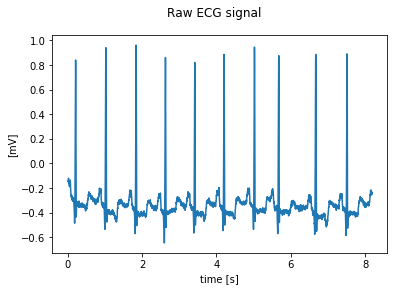

In [174]:
plt.suptitle('Raw ECG signal')
plt.xlabel('time [s]')
plt.ylabel('[mV]')
plt.plot(time_labels, ecg_signal)
plt.show()

In [175]:
# pan_tompkins_R_detector algorithm
ecg_signal = ecg_signal-np.mean(ecg_signal)
ecg_signal = ecg_signal / max(abs(ecg_signal)) # normalize to one

dcblock = np.zeros(samples_num)
for index in range(samples_num):
    if index >= 1:
        dcblock[index] = ecg_signal[index] - ecg_signal[index-1] + 0.995*dcblock[index-1]

dcblock = dcblock/ max(abs(dcblock))  # normalize to one

In [176]:
#low pass filter
# y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T) 
lowpass = np.zeros(samples_num)
for index in range(samples_num):
    if index >= 1:
        lowpass[index] += 2*lowpass[index-1]
    if index >= 2:
        lowpass[index] -= lowpass[index-2]
    lowpass[index] += dcblock[index]
    if index >= 6:
        lowpass[index] -= 2*dcblock[index-6]
    if index >=12:
        lowpass[index] += dcblock[index-12]

lowpass = lowpass/ max(abs(lowpass))  # normalize to one

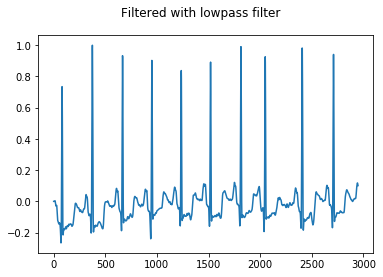

In [177]:
plt.suptitle('Filtered with lowpass filter')
plt.plot(lowpass)
plt.show()

In [178]:
#high pass
# y(nT) = 32x(nT - 16T) - [y(nT - T) + x(nT) - x(nT - 32T)]
highpass = np.zeros(samples_num)
for index in range(samples_num):
    if index >= 16:
        highpass[index] += 32 * lowpass[index-16]
    if index >= 1:
        highpass[index] -= highpass[index-1]
    highpass[index] = -lowpass[index]
    if index >= 32:
        highpass[index] += lowpass[index-32]

highpass = highpass/ max(abs(highpass))       # normalize to one

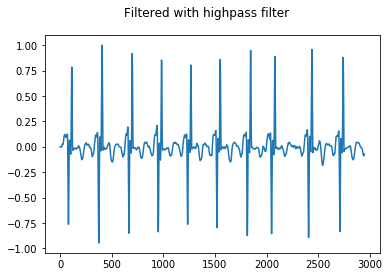

In [179]:
plt.suptitle('Filtered with highpass filter')
plt.plot(highpass)
plt.show()

In [180]:
#derivative
#y(nT) = 1/8 [−x(nT − 2T) − 2x(nT − T) + 2x(nT + T) + x(nT + 2T)]
d_signal = np.zeros(samples_num)
for index in range(samples_num):
    if index >= 2:
        d_signal[index] -= highpass[index-2]
    if index >= 1:
        d_signal[index] -= 2 * highpass[index-1]

    if index <= samples_num - 1 - 1:
        d_signal[index] += 2 * highpass[index+1]
    if index <= samples_num - 2 - 1:
        d_signal[index] += highpass[index+2]
    d_signal[index] /= 8
    
d_signal = d_signal/ max(abs(d_signal))  # normalize to one

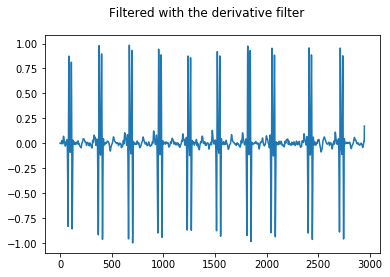

In [181]:
plt.suptitle('Filtered with the derivative filter')
plt.plot(d_signal)
plt.show()

In [182]:
# square signal
s_signal = np.square(d_signal)
s_signal = s_signal/ max(abs(s_signal))  # normalize to one

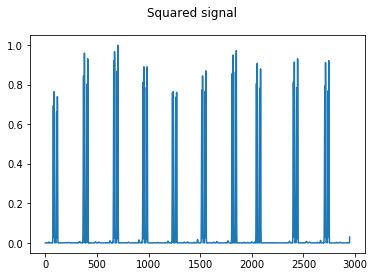

In [183]:
plt.suptitle('Squared signal')
plt.plot(s_signal)
plt.show()

In [184]:
#moving average
#y(nT) = (1/N)[x(nT - (N - 1)T) + x(nT - (N - 2)T) + ... x(nT)]
m_signal = (np.convolve(s_signal, np.ones((np.around(0.150 * freq).astype(int))) / np.around(0.15 * freq)))
m_signal = m_signal/ max(abs(m_signal)); # normalize to one


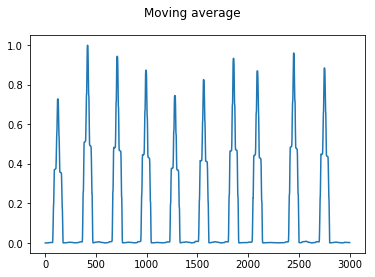

In [185]:
plt.suptitle('Moving average')
plt.plot(m_signal)
plt.show()

In [186]:
#find R peaks
peak_locs = scs.find_peaks_cwt(m_signal, widths=np.arange(1, 50), min_length=np.around(0.1 * freq))
peak_locs_fin = []
for pl in peak_locs:
    tmp_sig = m_signal[pl-50:min(pl + 50, len(m_signal))]
    ind = np.argmax(tmp_sig)
    peak_locs_fin.append(pl - 50 + ind)

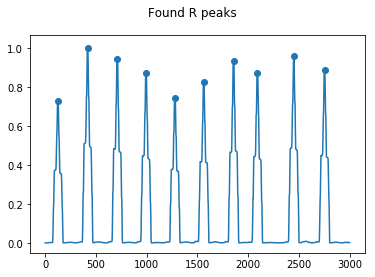

In [187]:
#plt.scatter(peak_locs_fin, m_signal[peak_locs_fin])
#plt.show()

max_val = np.max(list(map(lambda x: m_signal[x],peak_locs_fin)))
treshold =0.2* max_val
peak_final_final = np.array(list(filter(lambda x: m_signal[x] > treshold , peak_locs_fin)))

plt.suptitle('Found R peaks')
plt.scatter(peak_final_final, m_signal[peak_final_final])
plt.plot(m_signal)
plt.show()

In [188]:
#calculate heart rate
time =(len(m_signal)-1)/freq # in sec
r_pick_count = len(peak_final_final)
hearthrate= r_pick_count/time # uderzenia na sec
hearthrate = hearthrate * 60  # uderzenia na min

print('')
print('hearthrate = {}'.format(hearthrate))


hearthrate = 71.97600799733424


In [189]:
#RR interval calcualtion
t = samples_num * 1/freq
time_per_sample = t / len(m_signal)

RR_intervals = []

#normal RR interval should be 0.6-1.2 sec
for index in range(len(peak_final_final) - 1):
    diff = peak_final_final[index + 1] - peak_final_final[index]
    RR_intervals.append(diff * time_per_sample)
    print("RR interval: ", diff * time_per_sample , " s")

RR interval:  0.7995197646013769  s
RR interval:  0.7940622918054631  s
RR interval:  0.7749611370197647  s
RR interval:  0.7749611370197647  s
RR interval:  0.7804186098156785  s
RR interval:  0.8022485009993338  s
RR interval:  0.6385243171219187  s
RR interval:  0.9796163668665334  s
RR interval:  0.829535864978903  s


In [190]:
#RMSSD calculation
RMSSD = 0
for i in range(len(RR_intervals) - 1):
    RMSSD += (RR_intervals[i+1] - RR_intervals[i]) ** 2
RMSSD /= len(RR_intervals)
RMSSD = np.sqrt(RMSSD)
#RMSSD = np.log(RMSSD)
print("RMSSD: ", RMSSD)

RMSSD:  0.13604513879755953
